In [21]:
#importing package
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [22]:
#specifying parameters
stocks = ['JPM', 'C']
start = '2019-12-31'
end = '2021-03-08'
fee = 0.001
window = 252
t_threshold = -2.5
#retrieving data
data = pd.DataFrame()
returns = pd.DataFrame()
for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1 , 0)
    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


day 2020-12-30 00:00:00

no trading
gross daily return: [0.]%
net daily return: [0.]%
cumulative net return so far: 0.0%

day 2020-12-31 00:00:00

no trading
gross daily return: [0. 0.]%
net daily return: [0. 0.]%
cumulative net return so far: 0.0%

day 2021-01-04 00:00:00

no trading
gross daily return: [0. 0. 0.]%
net daily return: [0. 0. 0.]%
cumulative net return so far: 0.0%

day 2021-01-05 00:00:00

no trading
gross daily return: [0. 0. 0. 0.]%
net daily return: [0. 0. 0. 0.]%
cumulative net return so far: 0.0%

day 2021-01-06 00:00:00

no trading
gross daily return: [0. 0. 0. 0. 0.]%
net daily return: [0. 0. 0. 0. 0.]%
cumulative net return so far: 0.0%

day 2021-01-07 00:00:00

no trading
gross daily return: [0. 0. 0. 0. 0. 0.]%
net daily return: [0. 0. 0. 0. 0. 0.]%
cumulative net return so far: 0.0%

day 2021-01-08 00:00:00

no trading
gross daily return: [0. 0. 0. 0. 0. 0. 0.]%
net daily return: [0. 0. 0. 0. 0. 0. 0.]%
cumulative net return so far: 0.0%

day 2021-01-11 00:00

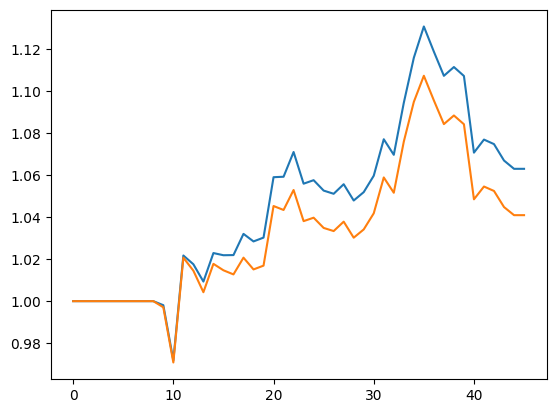

In [35]:
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
stock1 = stocks[0]
stock2 = stocks[1]
#moving through the samples
for t in range(window, len(data)):
    #defining the unit root function: stock2 = a + b*stock1
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
        fair_value = a + b*data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    res1 = spop.minimize(unit_root, data[stock2][t] / data[stock1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    fair_value = a_opt + b_opt*data[stock1][t]
    #optimising the cointegration equation parameters
    if t == window:
        old_signal = 0
    
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal * returns[stock2][t] - signal * returns[stock1][t]
    fees = fee * abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    #simulating trading
    print('day '+str(data.index[t]))
    print('')
    if signal == 0:
       print('no trading')
    elif signal == 1:
       print('long position on '+stock2 +' and short position on '+stock1)
    else:
        print('long position on ' + stock1 + ' and short position on ' + stock2)
    print('gross daily return: ' +str(np.round(gross_returns * 100, 2)) + '%')
    print('net daily return: ' + str(np.round(net_returns * 100, 2)) + '%')
    print('cumulative net return so far: '+str(np.round(np.prod(1 + net_returns) * 100 - 100, 2)) + '%')
    print('')
    old_signal = signal 
    #interface: reporting daily positions and realised returns
plt.plot(np.append(1, np.cumprod(1+gross_returns)))
plt.plot(np.append(1, np.cumprod(1+net_returns)))
#plotting equity curves